In [1]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU.")

Torch version: 2.5.1+cu121
CUDA available: True
Device: NVIDIA GeForce GTX 1650 Ti


In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms as T
from pathlib import Path

# Paths
DATA_ROOT = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\data\processed\classification\leukemia_classification")
TEST_DIR  = DATA_ROOT / "test"

# Transforms (same as validation)
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

val_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Dataset & loader
test_ds = ImageFolder(TEST_DIR, transform=val_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print("Test loader ready ✅")
print("Classes:", test_ds.classes, "| Samples:", len(test_ds))


Test loader ready ✅
Classes: ['all', 'hem'] | Samples: 1867


Using device: cuda


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31092\3327862874.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


Loaded checkpoint → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\checkpoints\classification\cls_leukemia_resnet18.pt
Classes: ['all', 'hem']


c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 


✅ Saved metrics → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\metrics\cls_leukemia_resnet18_test.json
Accuracy: 0.6529 | Macro AUROC: 0.5000


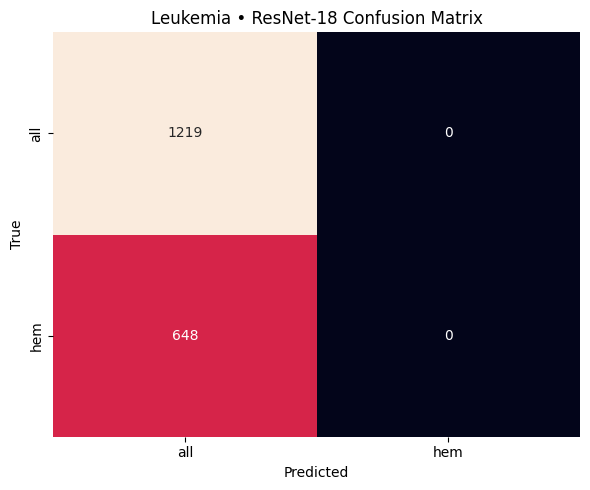

✅ Confusion matrix saved → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures\cls_leukemia_resnet18_confusion_matrix.png


In [4]:
# === Evaluate Saved ResNet-18 Model on Test Set ===
import json, torch, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torchmetrics.classification import MulticlassAUROC
from tqdm.auto import tqdm
from pathlib import Path

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load checkpoint ---
ckpt_path = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\checkpoints\classification\cls_leukemia_resnet18.pt")
state = torch.load(ckpt_path, map_location=device)

# Recreate model (must match training)
from torchvision import models
model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, state["num_classes"])
model.load_state_dict(state["state_dict"])
model = model.to(device).eval()

# Load class names and params
class_names = state["class_names"]
num_classes = state["num_classes"]
print("Loaded checkpoint →", ckpt_path)
print("Classes:", class_names)

# --- Run inference on test set ---
logits_list, targets_list = [], []
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing", leave=False):
        x = x.to(device)
        logits = model(x)
        logits_list.append(logits.cpu())
        targets_list.append(y.cpu())

logits = torch.cat(logits_list)
targets = torch.cat(targets_list)
probs = logits.softmax(1).numpy()
preds = probs.argmax(1)
targets_np = targets.numpy()

# --- Metrics ---
test_auroc = MulticlassAUROC(num_classes=num_classes, average="macro")(
    torch.tensor(probs), torch.tensor(targets_np)
).item()
test_acc = float((preds == targets_np).mean())

report = classification_report(targets_np, preds, target_names=class_names, output_dict=True)

# --- Save metrics JSON ---
MET_DIR = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\metrics")
MET_DIR.mkdir(parents=True, exist_ok=True)
out_json = MET_DIR / "cls_leukemia_resnet18_test.json"

with open(out_json, "w") as f:
    json.dump({
        "dataset": "leukemia",
        "model": "resnet18",
        "num_classes": num_classes,
        "test_macro_auroc": test_auroc,
        "test_accuracy": test_acc,
        "classification_report": report
    }, f, indent=2)

print(f"\n✅ Saved metrics → {out_json}")
print(f"Accuracy: {test_acc:.4f} | Macro AUROC: {test_auroc:.4f}")

# --- Confusion matrix ---
cm = confusion_matrix(targets_np, preds)
FIG_DIR = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Leukemia • ResNet-18 Confusion Matrix")
plt.tight_layout()

fig_path = FIG_DIR / "cls_leukemia_resnet18_confusion_matrix.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"✅ Confusion matrix saved → {fig_path}")


✅ Saved → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures\cls_leukemia_resnet18_confusion_matrix_counts.png


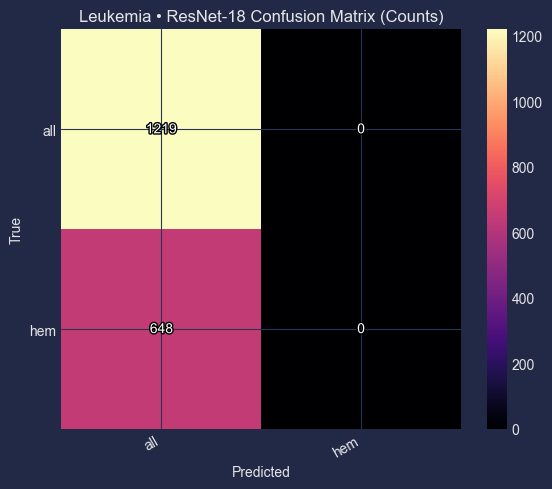

✅ Saved → C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures\cls_leukemia_resnet18_confusion_matrix_norm.png


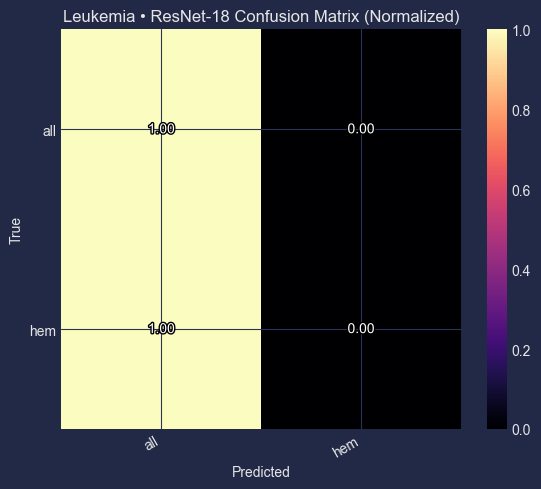

In [5]:
# --- Confusion Matrix (Cyberpunk Style) ---
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import mplcyberpunk

plt.style.use("cyberpunk")

def plot_confusion_matrix_cyberpunk(cm, class_names, title, save_path=None, normalize=False):
    cm_disp = cm.astype(float)
    if normalize:
        row_sums = cm_disp.sum(axis=1, keepdims=True).clip(min=1)
        cm_disp = cm_disp / row_sums

    fig, ax = plt.subplots(figsize=(7,5))
    im = ax.imshow(cm_disp, cmap="magma")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(np.arange(len(class_names)), labels=class_names, rotation=30, ha="right")
    ax.set_yticks(np.arange(len(class_names)), labels=class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm_disp[i, j]:.2f}" if normalize else f"{cm[i, j]}"
            ax.text(j, i, txt, ha="center", va="center", color="white", fontsize=10,
                    path_effects=[pe.withStroke(linewidth=2, foreground="black")])

    mplcyberpunk.make_lines_glow(ax=ax)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=150)
        print("✅ Saved →", save_path)
    plt.show()

# --- Compute and plot ---
cm = confusion_matrix(targets_np, preds)
REPO_ROOT = Path(r"C:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing")
FIG_DIR = REPO_ROOT / "results" / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)

plot_confusion_matrix_cyberpunk(
    cm,
    class_names,
    title="Leukemia • ResNet-18 Confusion Matrix (Counts)",
    save_path=FIG_DIR / "cls_leukemia_resnet18_confusion_matrix_counts.png",
    normalize=False
)

# --- Normalized version (optional) ---
plot_confusion_matrix_cyberpunk(
    cm,
    class_names,
    title="Leukemia • ResNet-18 Confusion Matrix (Normalized)",
    save_path=FIG_DIR / "cls_leukemia_resnet18_confusion_matrix_norm.png",
    normalize=True
)
